# Library import

In [1]:
#Import de librerias basicas tablas y matrices
import numpy as np 
import pandas as pd 

#Gradient Boosting
import lightgbm as lgb

#Funciones auxiliares sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold #Split y cross Validation
from sklearn.metrics import cohen_kappa_score, accuracy_score, balanced_accuracy_score #Metricas
from sklearn.utils import shuffle 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn import set_config



#Visualizacióon
import matplotlib.pyplot as plt
from plotly import express as px

#Plot de matriz de confusion normalizada en actuals
import sys
sys.path.append('../Scripts')
from utils import plot_confusion_matrix

import os

#Optimizacion de hiperparametros
import optuna
from optuna.artifacts import FileSystemArtifactStore, upload_artifact

#Guardado de objetos en archivos joblib
from joblib import load, dump

/home/ge/MCD/LaboII/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Env

In [2]:
# Paths para acceso archivos
#Este notebook asume la siguiente estructura de carpetas a partir de la ubicacion de base_dir 
#(dos niveles arriba de la carpeta donde se ejecuta el notebook). 
# /UA_MDM_LDI_II/
# /UA_MDM_LDI_II/input
# /UA_MDM_LDI_II/input/petfinder-adoption-prediction/            <- Aca deben ir todos los archivos de datos de la competencia 
# /UA_MDM_LDI_II/tutoriales/                       <- Aca deben poner los notebooks y scripts que les compartimos
# /UA_MDM_LDI_II/work/                             <- Resultados de notebooks iran dentro de esta carpeta en subcarpetas
# /UA_MDM_LDI_II/work/models/                     <- Modelos entrenados en archivos joblibs
# /UA_MDM_LDI_II/work/optuna_temp_artifacts/      <- Archivos que queremos dejar como artefacto de un trial de optuna (optuna los copiara a la carpeta de abajo)
# /UA_MDM_LDI_II/work/optuna_artifacts/           <- Archivos con artefactos que sibimos a optuna

#Subimos dos niveles para quedar en la carpeta que contiene input y UA_MDM_LDI_II
BASE_DIR = '../'

#Datos de entrenamiento 
PATH_TO_TRAIN = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/train/train.csv")
PATH_TO_TEST = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/test/test.csv")

#Salida de modelos entrenados
PATH_TO_MODELS = os.path.join(BASE_DIR, "work/models")

#Artefactos a subir a optuna
PATH_TO_TEMP_FILES = os.path.join(BASE_DIR, "work/optuna_temp_artifacts")

#Artefactos que optuna gestiona
PATH_TO_OPTUNA_ARTIFACTS = os.path.join(BASE_DIR, "work/optuna_artifacts")


SEED = 42 #Semilla de procesos aleatorios (para poder replicar exactamente al volver a correr un modelo)
TEST_SIZE = 0.2 #Facción para train/test= split

# Config for pandas output from pipelines
set_config(transform_output = "pandas")

In [3]:
# Datos Tabulares
df_train = pd.read_csv(PATH_TO_TRAIN)
df_train.shape

(14993, 24)

In [4]:
# Datos Tabulares
df_test = pd.read_csv(PATH_TO_TEST)
df_test.shape

(3972, 23)

In [5]:
# Otros archivos

# States diccionary
df_state_labels = pd.read_csv(os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/StateLabels.csv"))
df_state_labels['State_Pop'] = [
    3794,
    2194,
    1929,
    1746,
    100,
    937,
    1129,
    1685,
    2509,
    255,
    1774,
    3833,
    2822,
    6555,
    1275
]

### Categorical variables


| Variable       | Type         | Description                                                                           |
|----------------|--------------|---------------------------------------------------------------------------------------|
| `PetID`        | Categorical  | ID (Should be dropped)                                                                |
| `AdoptionSpeed`| Categorical  | Target variable                                                                       |
| `Type`         | Categorical  | 1 = Cat, 2 = Dog                                                                      |
| `Name`         | Categorical  | Name of pet                                                                           |
| `Breed1`       | Categorical  | See BreedLabels dictionary                                                            |
| `Breed2`       | Categorical  | See BreedLabels dictionary                                                            |
| `Gender`       | Categorical  | 1 = Male, 2 = Female, 3 = Mixed (used for groups)                                     |
| `Color1`       | Categorical  | See ColorLabels dictionary                                                            |
| `Color2`       | Categorical  | See ColorLabels dictionary                                                            |
| `Color3`       | Categorical  | See ColorLabels dictionary                                                            |
| `MaturitySize` | Categorical  | 1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified                  |
| `FurLength`    | Categorical  | 1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified                                    |
| `Vaccinated`   | Categorical  | 1 = Yes, 2 = No, 3 = Not Sure                                                         |
| `Dewormed`     | Categorical  | 1 = Yes, 2 = No, 3 = Not Sure                                                         |
| `Sterilized`   | Categorical  | 1 = Yes, 2 = No, 3 = Not Sure                                                         |
| `Health`       | Categorical  | 1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified                  |
| `State`        | Categorical  | See StateLabels dictionary                                                            |
| `RescuerID`    | Categorical  | ID                                                                                    |
| `Description`  | Text         | Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese. |

### Quantitative Variables

| Variable   | Type             |Description                                           |
|------------|------------------|------------------------------------------------------|
| `Age`      |  Numerical       |Age of pet when listed, in months                     |
| `Quantity` |  Numerical       |Number of pets represented in profile                 |
| `Fee`      |  Numerical       |Adoption fee (0 = Free)                               |
| `VideoAmt` |  Numerical       |Total uploaded videos for this pet                    |
| `PhotoAmt` |  Numerical       |Total uploaded photos for this pet                    |

# Feature Engineering

La funcion apply_fe servira para generar las variables nuevas en base a los datos tabulares disponibles

In [6]:

def apply_fe(dataset):
    # Name
    # Feature to know if the pet has a name
    unknown_names = 'name|puppies|kitten|puppy|unknown'
    dataset['Name'] = np.where(dataset['Name'].str.lower().str.contains(unknown_names), np.nan, dataset['Name'])
    dataset['Name'] = np.where(dataset['Name'].str.len() < 3, np.nan, dataset['Name'])
    dataset['HasName'] = dataset['Name'].apply(lambda x: 0 if pd.isnull(x) else 1)

    
    # Breed
    # Unify values in Breed1
    dataset['Breed1'] = np.where((dataset['Breed1']==0) & (dataset['Breed2']!=0), dataset['Breed2'], dataset['Breed1'])
    dataset['Breed2'] = np.where((dataset['Breed1']==dataset['Breed2']), 0, dataset['Breed2'])
    
    # Merge Breed1 and Breed2
    dataset['FullBreed'] = dataset['Breed1'].astype(str) + '_' + dataset['Breed2'].astype(str) 
    # Pure breed
    dataset['PureBreed'] = np.where((dataset['Breed2'] == 0) & (~dataset['Breed1'].isin([307, 266, 265, 264])), 1, 0)
    
    # Color
    # Merge Color1, Color2 and Color3
    dataset['Color'] = dataset['Color1'].astype(str) + '_' + dataset['Color2'].astype(str) + '_' + dataset['Color3'].astype(str)
    # Monochromatic
    dataset['Monochromatic'] = np.where((dataset['Color2'] == 0) & (dataset['Color3'] == 0), 1, 0)
    
    # Health
    # Merge Vaccinated, Dewormed and Sterilized to know if the pet is up to date with routine stuff
    dataset['Va_De_St'] = dataset['Vaccinated'].astype(str) + '_' + dataset['Dewormed'].astype(str) + '_' + dataset['Sterilized'].astype(str)

    # Code to add a min age for sterilization.... But EDA shows that they do it anyway
    #df['CanBeSter'] = np.where((df['Age'] > 9) & (df['Type'] == 1) | (df['Age'] > 6) & (df['Type'] == 2), 1, 0)
    
    # Fee
    # Create fee bins using log transformation
    dataset['Fee_bins'] = pd.cut(np.log1p(dataset.Fee), 5, labels=['Fee_{}'.format(e) for e in range(5)])

    #RescuerID
    rescuer_count = dataset.groupby(['RescuerID'])['PetID'].count().reset_index()
    rescuer_count.columns = ['RescuerID', 'Rescuer_count']
    dataset = dataset.merge(rescuer_count, how='left', on='RescuerID')

    # Age
    dataset['RelAge'] = np.where(dataset['Type'] == 1, dataset['Age']/144, dataset['Age']/180) # Vida media de un gato 12 años, de un perro 15

    # Multimedia
    dataset['Total_photo_video'] = dataset['PhotoAmt'] + dataset['VideoAmt']

    # Si tiene todo lo del veterinatrio en orden
    dataset['VetInOrder'] = np.where((dataset['Vaccinated'] == 1) & (dataset['Dewormed'] == 1) & (dataset['Sterilized'] == 1) & (dataset['Health'] == 1), 1, 0)

    # Si le falta info sobre lo relacionado a veterinario
    dataset['NoVet'] = np.where((dataset['Vaccinated'] == 3) | (dataset['Dewormed'] == 3) | (dataset['Sterilized'] == 3) | (dataset['Health'] == 3), 1, 0)

    # Longitud de la descripcion
    dataset['LenDesc'] = dataset['Description'].apply(lambda x: len(str(x)))

    # variable "age_categ" para categorizar age (identica para perros y gatos, sin problemas según fuentes)
    age_categ_cuts = [
        (dataset['Age'].le(1*12)),
        (dataset['Age'].gt(1*12) & dataset['Age'].le(3*12)),
        (dataset['Age'].gt(3*12) & dataset['Age'].le(9*12)),
        (dataset['Age'].gt(9*12))   
    ]
    age_categ_values = ["baby","young","adult","old"]
    dataset['Age_categ'] = np.select(age_categ_cuts, age_categ_values)

    # variable "individual" para saber si es un animal solo o un grupo
    dataset['Individual'] = np.where((dataset['Quantity'].gt(1)),1,0)

    #variable "free" para saber si hay que pagar o no por adoptar
    dataset['Free'] = np.where((dataset['Fee'].gt(0)),1,0)

    # agrego state label y state population
    dataset = pd.merge(dataset, df_state_labels, how = "left", left_on='State',right_on='StateID')

    # Return the augmented dataset
    return dataset

In [7]:
df_train = apply_fe(df_train.copy())
df_test = apply_fe(df_test.copy())

# Entrenamiento del modelo

Para poder evaluar el modelo entrenado, se realiza un split de los datos de entrenamiento en train y validacion con un tamaño 80/20%

In [8]:
y = df_train['AdoptionSpeed']
X = df_train.drop(columns=['AdoptionSpeed'])

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=SEED, 
                                                    stratify=y)

A continuación se genera una nueva variable que utiliza la variable objetivo como un input y se agrega la misma a las DataFrame de train y validación. Se hace el calculo después del split para no ensuciar los datos con los que se evaluará el modelo

In [10]:
# Calculate the mean adoption speed per state and add that value to train and test datasets
state_mean = pd.concat([X_train['State'], y_train], axis=1).groupby('State')['AdoptionSpeed'].mean().reset_index()
state_mean.columns = ['State', 'AdoptionSpeed_mean']
X_train = X_train.merge(state_mean, how='left', on='State')
X_val = X_val.merge(state_mean, how='left', on='State')

Luego de las transformaciones nos quedamos con las siguientes columnas que agregamos a listas dependiendo del tipo de variable que son y transformarla en base a eso:

* Variables categóricas: Se codifican segun su valor de manera ordinal si se encuentran en al menos 50 observaciones. Caso de que se observen menor cantidad de veces se codifican como otros. Este punto de corte fue encontrado empíricamente en base al valor de la métrica objetivo.
* Variables numéricas: No es necesaria ninguna transformación para el algoritmo LightGBM
* Variables descartadas: `PetID` por ser un número identificatorio sin relevaciancia predictiva y `Description` ya que no estamos haciendo una evaluación del texto que describe la mascota en el modelo tabular

In [11]:
X_train.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'HasName', 'FullBreed',
       'PureBreed', 'Color', 'Monochromatic', 'Va_De_St', 'Fee_bins',
       'Rescuer_count', 'RelAge', 'Total_photo_video', 'VetInOrder', 'NoVet',
       'LenDesc', 'Age_categ', 'Individual', 'Free', 'StateID', 'StateName',
       'State_Pop', 'AdoptionSpeed_mean'],
      dtype='object')

In [12]:
#Armo listas con features de texto y numericas
char_feats = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized','Health', 'State', 'RescuerID',
       'Description', 'HasName', 'FullBreed',
       'PureBreed', 'Color', 'Monochromatic', 'Va_De_St', 'Fee_bins', 'VetInOrder', 'NoVet','VideoAmt','PhotoAmt','Total_photo_video', 'Name',
       'Age_categ', 'Individual', 'Free', 'StateName'
       ]
#
numeric_feats = ['Age', 'Quantity', 'Fee', 'RelAge',
       'Rescuer_count', 'LenDesc', 'AdoptionSpeed_mean', ]

fe_drop = ['PetID','Description']

In [13]:
X_train_id = X_train['PetID']
X_train = X_train[char_feats + numeric_feats]

X_val_id = X_val['PetID']

#X_val_id.to_csv(os.path.join(BASE_DIR, "input/val_id.csv'), index=False)
X_val = X_val[char_feats + numeric_feats]

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(min_frequency= 50, handle_unknown= 'use_encoded_value', unknown_value= -1), char_feats)],
        remainder= 'passthrough')

In [15]:
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)

Se entrena un primer modelo para evaluar las variables creadas y la importancia de las variables del modelo

In [16]:
#Entreno un modelo inicial sin modificar hiperparametros. Solamente especifico el numero de clases y el tipo de modelo como clasificacoión
lgb_params = params = {
                        'objective': 'multiclassova',
                        'num_class': 5,
                        'learning_rate': 0.01,
                        'n_estimators': 1000,
                        'device': 'cpu'
                        }


#genero el objeto Dataset que debo pasarle a lightgbm para que entrene
lgb_train_dataset = lgb.Dataset(data=X_train,
                                label=y_train)

#entreno el modelo con los parametros por defecto
lgb_model = lgb.train(lgb_params,
                      lgb_train_dataset)

[LightGBM] [Info] Number of positive: 328, number of negative: 11666
[LightGBM] [Info] Number of positive: 2472, number of negative: 9522
[LightGBM] [Info] Number of positive: 3230, number of negative: 8764
[LightGBM] [Info] Number of positive: 2607, number of negative: 9387
[LightGBM] [Info] Number of positive: 3357, number of negative: 8637
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 826
[LightGBM] [Info] Number of data points in the train set: 11994, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.027347 -> initscore=-3.571420
[LightGBM] [Info] Start training from score -3.571420
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.206103 -> initscore=-1.348577
[LightGBM] [Info] Start training from score -1.348577
[LightGBM] [Info] [binary:BoostFrom

In [17]:
y_pred = lgb_model.predict(X_val).argmax(axis=1)

#Calculo el Kappa
cohen_kappa_score(y_val,y_pred, weights = 'quadratic')

0.3271259225867651

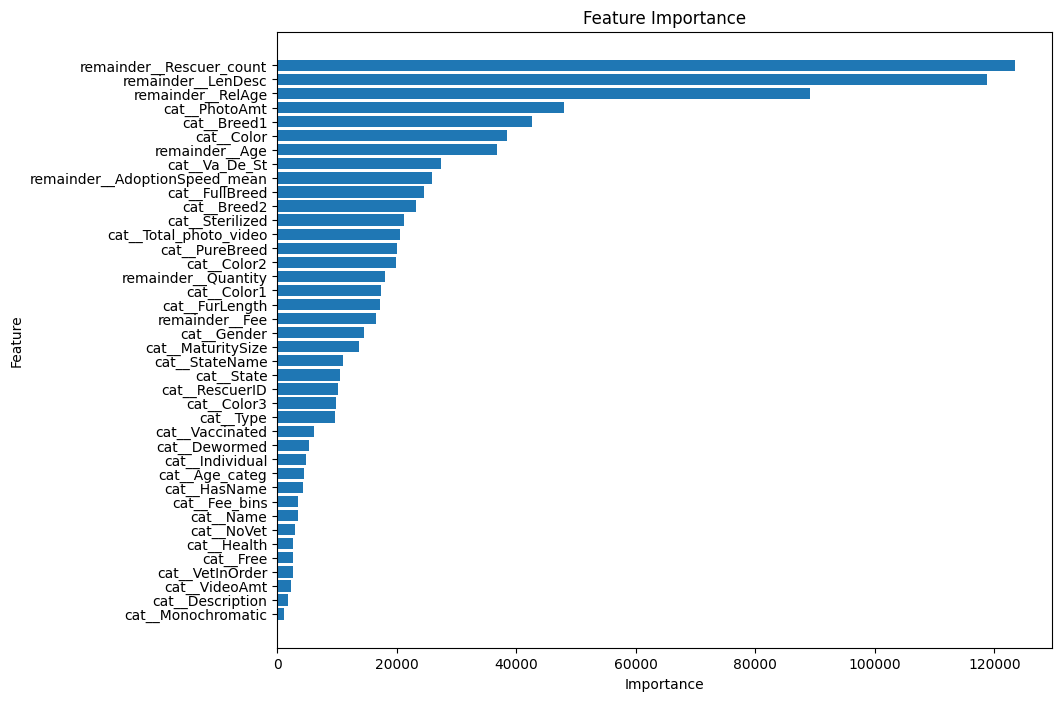

In [18]:
feature_importance = pd.DataFrame({'feature': preprocessor.get_feature_names_out(), 'weight': lgb_model.feature_importance(importance_type='gain')})

# Sort feature importance
feature_importance = feature_importance.sort_values('weight', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'], feature_importance['weight'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

Como ninguna variable perjudica el poder predictivo y la cantidad de variables no es excesivo para el poder de computo disponible se decide dejar todas las varibles

# Optimización de los hyperparametros

In [19]:
#Genero una metrica para que lightGBM haga la evaluación y pueda hacer early_stopping en el cross validation
def lgb_custom_metric_kappa(dy_pred, dy_true):
    metric_name = 'kappa'
    value = cohen_kappa_score(dy_true.get_label(),dy_pred.argmax(axis=1),weights = 'quadratic')
    is_higher_better = True
    return(metric_name, value, is_higher_better)

#Funcion objetivo a optimizar. En este caso vamos a hacer 5fold cv sobre el conjunto de train. 
# El score de CV es el objetivo a optimizar. Ademas vamos a usar los 5 modelos del CV para estimar el conjunto de test,
# registraremos en optuna las predicciones, matriz de confusion y el score en test.
# CV Score -> Se usa para determinar el rendimiento de los hiperparametros con precision 
# Test Score -> Nos permite testear que esta todo OK, no use (ni debo usar) esos datos para nada en el entrenamiento 
# o la optimizacion de hiperparametros

def cv_es_lgb_objective(trial):

    #PArametros para LightGBM
    lgb_params = {      
                        #PArametros fijos
                        'objective': 'multiclassova',
                        'verbosity':-1,
                        'num_class': len(y_train.unique()),
                        'seed': SEED,
                        
                        #Hiperparametros a optimizar utilizando suggest_float o suggest_int segun el tipo de dato
                        #Se indica el nombre del parametro, valor minimo, valor maximo 
                        #en elgunos casos el parametro log=True para parametros que requieren buscar en esa escala
                        'lambda_l1': trial.suggest_float('lambda_l1', 1e-6, 1e-2, log=True),
                        'lambda_l2': trial.suggest_float('lambda_l2', 1e-5, 0.01, log=True),
                        'num_leaves': trial.suggest_int('num_leaves', 100, 256),
                        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
                        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 40),
                        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 0.8),
                        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 0.9),
                        'bagging_freq': trial.suggest_int('bagging_freq', 1, 3),
                        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
                        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
                        'min_split_gain': trial.suggest_float('min_split_gain', 1, 6),
                        "max_bin": trial.suggest_int('max_bin', 300, 500),
                        } 

    #Voy a generar estimaciones de los 5 modelos del CV sobre los datos test y los acumulo en la matriz scores_ensemble
    scores_ensemble = np.zeros((len(y_val),len(y_train.unique())))

    #Score del 5 fold CV inicializado en 0
    score_folds = 0

    #Numero de splits del CV
    n_splits = 5

    #Objeto para hacer el split estratificado de CV
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (if_index, oof_index) in enumerate(skf.split(X_train, y_train)):
        
        #Dataset in fold (donde entreno) 
        lgb_if_dataset = lgb.Dataset(data=X_train.iloc[if_index],
                                        label=y_train.iloc[if_index],
                                        free_raw_data=False)
        
        #Dataset Out of fold (donde mido la performance del CV)
        lgb_oof_dataset = lgb.Dataset(data=X_train.iloc[oof_index],
                                        label=y_train.iloc[oof_index],
                                        free_raw_data=False)

        #Entreno el modelo
        lgb_model = lgb.train(lgb_params,
                                lgb_if_dataset,
                                valid_sets=lgb_oof_dataset,
                                feval = lgb_custom_metric_kappa
                                )
        
        #Acumulo los scores (probabilidades) de cada clase para cada uno de los modelos que determino en los folds
        #Se predice el 20% de los datos que separe para tes y no uso para entrenar en ningun fold
        scores_ensemble = scores_ensemble + lgb_model.predict(X_val)
        
        #Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds = score_folds + cohen_kappa_score(y_train.iloc[oof_index], 
                                                            lgb_model.predict(X_train.iloc[oof_index]).argmax(axis=1),weights = 'quadratic')/n_splits


    #Guardo prediccion del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES,f'test_{trial.study.study_name}_{trial.number}.joblib')
    # Copia del dataset para guardar la prediccion
    predicted_df = pd.DataFrame(X_val,y_val).copy()
    # Genero columna pred con predicciones sumadas de los 5 folds
    predicted_df['pred'] = [scores_ensemble[p,:] for p in range(scores_ensemble.shape[0])]
    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    # Indico a optuna que asocie el archivo generado al trial
    #upload_artifact(trial, predicted_filename, artifact_store)    

    #Grabo natriz de confusion
    #Nombre de archivo
    cm_filename = os.path.join(PATH_TO_TEMP_FILES,f'cm_{trial.study.study_name}_{trial.number}.jpg')
    #Grabo archivo
    plot_confusion_matrix(y_val,scores_ensemble.argmax(axis=1)).write_image(cm_filename)
    #Asocio al trial
    #upload_artifact(trial, cm_filename, artifact_store)

    #Determino score en conjunto de test y asocio como metrica adicional en optuna
    test_score = cohen_kappa_score(y_val,scores_ensemble.argmax(axis=1),weights = 'quadratic')
    trial.set_user_attr("test_score", test_score)

    #Devuelvo score del 5fold cv a optuna para que optimice en base a eso
    return(score_folds)

In [20]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

#Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///../work/db.sqlite3",  # Specify the storage URL here.
                            study_name="Final - Ge - LGB Multiclass CV 13102024",
                            load_if_exists = True)
#Corro la optimizacion
run_optuna = False
optuna.logging.set_verbosity(optuna.logging.WARNING)
if run_optuna:
    study.optimize(cv_es_lgb_objective, n_trials=100, show_progress_bar = True)
# Guardo los mejores hiperparametros
lgbm_params = study.best_params

[I 2024-10-14 22:36:06,417] Using an existing study with name 'Final - Ge - LGB Multiclass CV 13102024' instead of creating a new one.


In [21]:
#!optuna-dashboard sqlite:///../work/db.sqlite3 --artifact-dir ../work/optuna_artifacts --port 8081

Resultados de los 10 mejores parametros

In [22]:
sorted_trials = sorted(study.get_trials(), key=lambda trial: trial.value, reverse=True)[:10]
for trial in sorted_trials:
    print(f"Trial {trial.number} - {trial.value}: {trial.params}")

Trial 93 - 0.397120671453317: {'lambda_l1': 4.697131335007363e-06, 'lambda_l2': 0.004696103784321398, 'num_leaves': 190, 'learning_rate': 0.007606036001432134, 'min_data_in_leaf': 5, 'feature_fraction': 0.7706742207041094, 'bagging_fraction': 0.6149712062788686, 'bagging_freq': 1, 'min_child_samples': 33, 'n_estimators': 705, 'min_split_gain': 1.0814103399541026, 'max_bin': 380}
Trial 12 - 0.3963923526769226: {'lambda_l1': 0.007932469053922558, 'lambda_l2': 0.009714119568746567, 'num_leaves': 152, 'learning_rate': 0.04149808181455818, 'min_data_in_leaf': 5, 'feature_fraction': 0.7805136900897587, 'bagging_fraction': 0.6041613680365248, 'bagging_freq': 1, 'min_child_samples': 34, 'n_estimators': 732, 'min_split_gain': 1.0246193696762793, 'max_bin': 337}
Trial 57 - 0.3957767705354339: {'lambda_l1': 2.2730220624495335e-05, 'lambda_l2': 0.008008982262809073, 'num_leaves': 180, 'learning_rate': 0.03821627280197169, 'min_data_in_leaf': 10, 'feature_fraction': 0.7572117588840829, 'bagging_fra

# Modelo final

In [23]:
#Vamos a replicar el resultado de la optimizacion reentrenando el modelo con el mejor conjunto de hiperparametros
#Generamos parametros incluyendo los fijos y la mejor solución que encontro optuna
lgb_params =  {      **lgbm_params,
                        'objective': 'multiclassova',
                        'verbosity':-1,
                        'num_class': len(y_train.unique())}

lgb_train_dataset = lgb.Dataset(data=X_train,
                                label=y_train)


#Entreno
lgb_model = lgb.train(lgb_params,
                    lgb_train_dataset)

lgb_proba = lgb_model.predict(X_val)
lgb_pred = lgb_model.predict(X_val).argmax(axis=1)

#Muestro matriz de confusion y kappa
display(plot_confusion_matrix(y_val, lgb_pred))

cohen_kappa_score(y_val,lgb_pred,
                  weights = 'quadratic')


0.3533306729890443

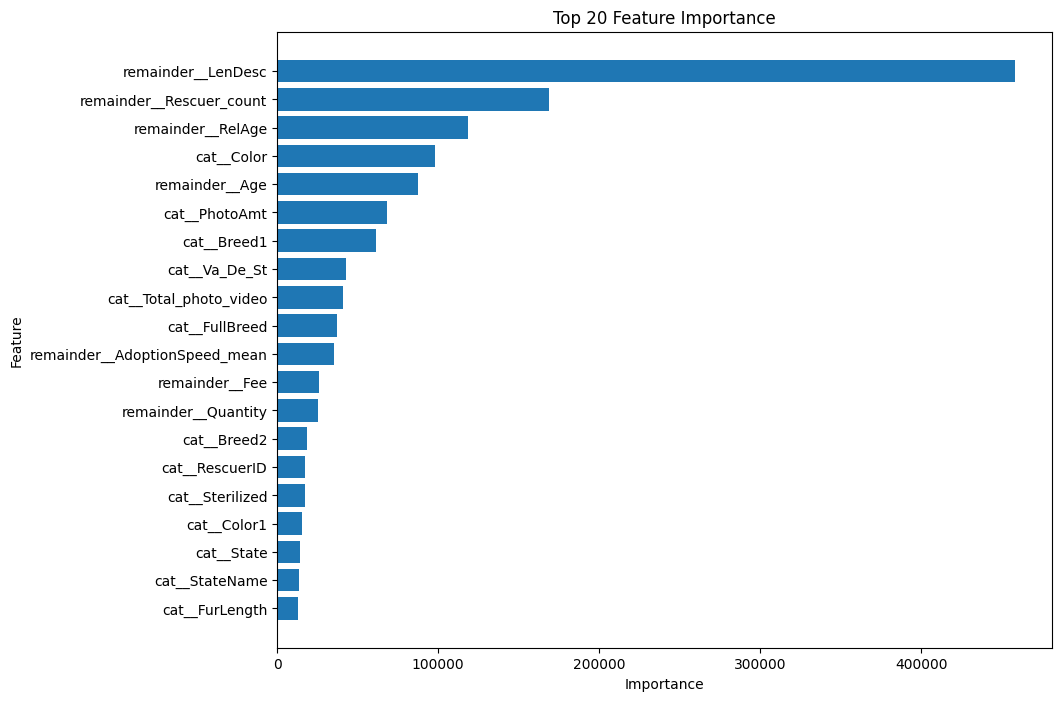

In [24]:
feature_importance = pd.DataFrame({'feature': preprocessor.get_feature_names_out(), 'weight': lgb_model.feature_importance(importance_type='gain')})
feature_importance = feature_importance.sort_values('weight', ascending=False).head(20)
# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'], feature_importance['weight'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance')
plt.gca().invert_yaxis()
plt.show()


# Blend

## Bert and resnet

En maquinas virtuales con GPU se corrieron modelos predictivos en base a imagenes y texto que predijeron la clase final para cada observacion de nuestros datos de entrenamiento para hacer un blend de modelos con la esperanza de que mejore la métrica.

El primer blend utiliza la red ResNet como base para hacer predicciones en base a una unica imagen por cada observacion y la red Bert para hacer la clasificacione en base al texto en `Description`

In [49]:
nn_proba_res = load(os.path.join(BASE_DIR, "resultados_nn_bert/test_04 ResNet__1.0.0_0.joblib"))
nn_proba_res = nn_proba_res[['PetID', 'pred']]

bert_proba = load(os.path.join(BASE_DIR, "resultados_nn_bert/test_06 Bert_1.0_3.joblib"))
bert_proba = bert_proba[['PetID', 'pred']]

In [50]:
lgb_proba_df = pd.DataFrame({'PetID': X_val_id,
                            'lgbm_proba': list(lgb_proba)})

all_proba = lgb_proba_df.merge(bert_proba[['PetID', 'pred']].rename({'pred':'bert_proba'},axis=1),
                  on='PetID', how='left').merge(nn_proba_res[['PetID', 'pred']].rename({'pred':'nn_proba_ResNet'},axis=1),
                  on='PetID', how='left').merge(df_train[['PetID','AdoptionSpeed']], on='PetID', how='left')

all_proba['bert_proba'] = [np.zeros(5) if type(i) is float else  i for i in all_proba['bert_proba']]
all_proba['nn_proba_ResNet'] = [np.zeros(5) if type(i) is float else  i for i in all_proba['nn_proba_ResNet']]

In [51]:
y = all_proba['AdoptionSpeed']

### Optimizacion de los pesos para cada modelo

In [52]:
def objective(trial):
    # Suggest weights for each model's predictions
    w_lgbm = trial.suggest_float('w_lgbm', 0.5, 1.0)
    w_bert = trial.suggest_float('w_bert', 0.0, 0.5)
    w_nn_res = trial.suggest_float('w_nn', 0.0, 0.5)

    # Normalize weights
    w_sum = w_lgbm + w_bert + w_nn_res
    w_lgbm /= w_sum
    w_bert /= w_sum
    w_nn_res /= w_sum
    # Calculate the blended predictions
    y_pred = np.array((w_lgbm* all_proba['lgbm_proba']+ 
                        w_bert * all_proba['bert_proba']+
                        w_nn_res* all_proba['nn_proba_ResNet']).tolist()).argmax(axis=1)
    
    # Calculate the quadratic weighted kappa
    kappa = cohen_kappa_score(y, y_pred, weights='quadratic')

    return kappa

# Create an Optuna study
optuna.logging.set_verbosity(optuna.logging.WARNING)
#optuna.logging.set_verbosity(optuna.logging.INFO)
study_blend = optuna.create_study(direction="maximize")
study_blend.optimize(objective, n_trials=400, show_progress_bar = True)

# Best weights found
best_weights = study_blend.best_trial.params
print("Best weights:", best_weights)

Best trial: 271. Best value: 0.425546: 100%|██████████| 400/400 [00:12<00:00, 31.34it/s]

Best weights: {'w_lgbm': 0.8918273684383955, 'w_bert': 0.18653853630479023, 'w_nn': 0.12153936727177415}


Kappa blend 0.4255461737732995, 
Kappa LGBM: 0.3533306729890443, 
Kappa NN_resnet: 0.2701857779092195, 
Kappa BERT: 0.2497737871153365


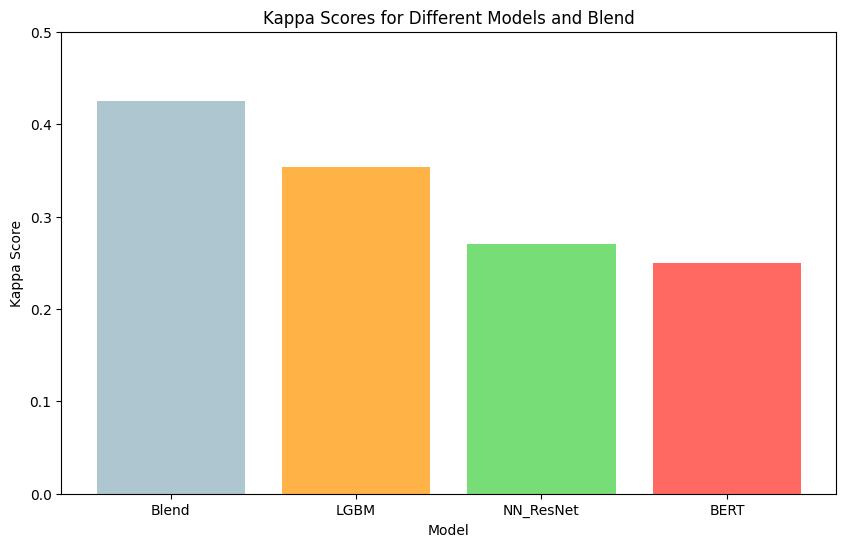

In [53]:
# Calculate the quadratic weighted kappa
lgbm_kappa = cohen_kappa_score(y, np.array(all_proba['lgbm_proba'].tolist()).argmax(axis=1), weights='quadratic')
# Calculate the quadratic weighted kappa
bert_kappa = cohen_kappa_score(y, np.array(all_proba['bert_proba'].tolist()).argmax(axis=1), weights='quadratic')
# Calculate the quadratic weighted kappa
nn_Res_kappa = cohen_kappa_score(y, np.array(all_proba['nn_proba_ResNet'].tolist()).argmax(axis=1), weights='quadratic')
print(f"Kappa blend {study_blend.best_value}, \nKappa LGBM: {lgbm_kappa}, \nKappa NN_resnet: {nn_Res_kappa}, \nKappa BERT: {bert_kappa}")
# Create a bar plot to represent the kappa values
kappa_values = {    
    'Blend': study_blend.best_value,
    'LGBM': lgbm_kappa,
    'NN_ResNet': nn_Res_kappa,
    'BERT': bert_kappa
}
colors = ['#AEC6CF', '#FFB347', '#77DD77', '#FF6961']
plt.figure(figsize=(10, 6))
plt.bar(kappa_values.keys(), kappa_values.values(), color=colors)
plt.xlabel('Model')
plt.ylabel('Kappa Score')
plt.title('Kappa Scores for Different Models and Blend')
plt.ylim(0, 0.5)
plt.show()

Haciendo un mix entre los tres modelos, obtenemos una mejora sustancial en la capacidad predictiva comparandolo a cada modelo individual

## Bert, ResNet y Effnet

Como complemento, se suma las predicciones hechas por un modelo basado en la red EffNet

In [54]:
nn_proba_eff = load(os.path.join(BASE_DIR, "resultados_nn_bert/test_04 Effnet_1.0.0_0.joblib"))
nn_proba_eff = nn_proba_eff[['PetID', 'pred']]

all_proba = all_proba.merge(nn_proba_eff[['PetID', 'pred']].rename({'pred':'nn_proba_Effnet'},axis=1),
                  on='PetID', how='left')

all_proba['nn_proba_Effnet'] = [np.zeros(5) if type(i) is float else i for i in all_proba['nn_proba_Effnet']]

In [55]:
def objective(trial):
    # Suggest weights for each model's predictions
    w_lgbm = trial.suggest_float('w_lgbm', 0.5, 1.0)
    w_bert = trial.suggest_float('w_bert', 0.0, 0.5)
    w_nn_res = trial.suggest_float('w_nn_res', 0.0, 0.5)
    w_nn_eff = trial.suggest_float('w_nn_eff', 0.0, 0.5)

    # Normalize weights
    w_sum = w_lgbm + w_bert + w_nn_res + w_nn_eff
    w_lgbm /= w_sum
    w_bert /= w_sum
    w_nn_res /= w_sum
    w_nn_eff /= w_sum

    # Calculate the blended predictions
    y_pred = np.array((w_lgbm* all_proba['lgbm_proba']+ 
                        w_bert * all_proba['bert_proba']+
                        w_nn_res* all_proba['nn_proba_ResNet']+
                        w_nn_eff*all_proba['nn_proba_Effnet']).tolist()).argmax(axis=1)
    
    # Calculate the quadratic weighted kappa
    kappa = cohen_kappa_score(y, y_pred, weights='quadratic')

    return kappa

# Create an Optuna study
optuna.logging.set_verbosity(optuna.logging.WARNING)
#optuna.logging.set_verbosity(optuna.logging.INFO)
study_blend_final = optuna.create_study(direction="maximize")
study_blend_final.optimize(objective, n_trials=400, show_progress_bar = True)

# Best weights found
best_weights = study_blend_final.best_trial.params
print("Best weights:", best_weights)

Best trial: 389. Best value: 0.430302: 100%|██████████| 400/400 [00:16<00:00, 23.87it/s]

Best weights: {'w_lgbm': 0.9301243607090792, 'w_bert': 0.1602519836439884, 'w_nn_res': 0.09816602464640131, 'w_nn_eff': 0.05542625478304978}


Kappa blend final 0.4303016262791789, 
Kappa blend 0.4255461737732995, 
Kappa LGBM: 0.3533306729890443, 
Kappa NN_resnet: 0.2701857779092195, 
Kappa BERT: 0.2497737871153365, 
Kappa NN_effnet: 0.22677179346234155


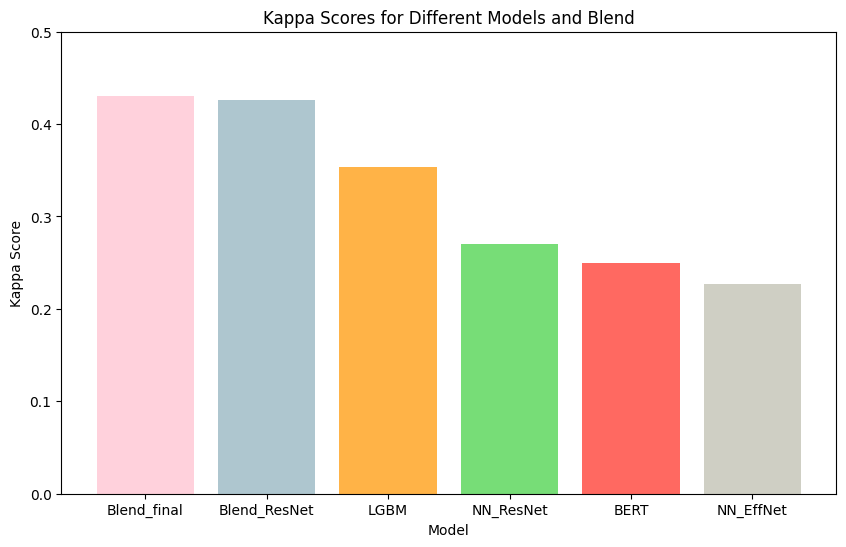

In [56]:
# Calculate the quadratic weighted kappa
nn_eff_kappa = cohen_kappa_score(y, np.array(all_proba['nn_proba_Effnet'].tolist()).argmax(axis=1), weights='quadratic')
print(f"Kappa blend final {study_blend_final.best_value}, \nKappa blend {study_blend.best_value}, \nKappa LGBM: {lgbm_kappa}, \nKappa NN_resnet: {nn_Res_kappa}, \nKappa BERT: {bert_kappa}, \nKappa NN_effnet: {nn_eff_kappa}")

kappa_values = {
    'Blend_final': study_blend_final.best_value,    
    'Blend_ResNet': study_blend.best_value,
    'LGBM': lgbm_kappa,
    'NN_ResNet': nn_Res_kappa,
    'BERT': bert_kappa,
    'NN_EffNet': nn_eff_kappa
}
colors = ['#FFD1DC','#AEC6CF', '#FFB347', '#77DD77', '#FF6961', '#CFCFC4']
plt.figure(figsize=(10, 6))
plt.bar(kappa_values.keys(), kappa_values.values(), color=colors)
plt.xlabel('Model')
plt.ylabel('Kappa Score')
plt.title('Kappa Scores for Different Models and Blend')
plt.ylim(0, 0.5)
plt.show()

Este segundo modelo de imágenes, es claramente peor que ResNet según la métrica, pero al sumarlo al blend obtenemos una pequeña mejora lo cual demuestra que,

* Los modelos preentrenados capturan diferentes características de las imágenes
* La técnica de hacer una mezcla de diferentes modelos es efectiva a pesar de que se esten predigan en base a la mismas variables de entrada

# Conclusión

En este notebook, se ha desarrollado un modelo de predicción de la velocidad de adopción de mascotas utilizando una combinación de técnicas de aprendizaje automático y procesamiento de datos. A continuación, se resumen los puntos clave y conclusiones obtenidas:

1. **Preprocesamiento y Feature Engineering**:
    * Se realizaron diversas transformaciones y creación de nuevas variables a partir de los datos originales, como la unificación de razas, colores, y la creación de variables indicadoras.
    * Se utilizaron técnicas de codificación ordinal para las variables categóricas y se aplicaron transformaciones logarítmicas para algunas variables numéricas.

2. **Entrenamiento del Modelo**:
    * Se entrenó un modelo inicial utilizando LightGBM con parámetros por defecto y se evaluó su rendimiento utilizando la métrica de Kappa ponderada.
    * Se realizó una optimización de hiperparámetros utilizando Optuna para mejorar el rendimiento del modelo.

4. **Blend de Modelos**:
    * Se combinaron las predicciones de diferentes modelos (LightGBM, ResNet, BERT y EffNet) para mejorar la capacidad predictiva.
    * La combinación de modelos demostró ser efectiva, capturando diferentes características de las imágenes y textos, y mejorando la métrica de Kappa ponderada.

5. **Optimización de Pesos**:
    * Se optimizaron los pesos de cada modelo en el blend utilizando Optuna, logrando una mejora sustancial en la capacidad predictiva comparada con cada modelo individual.

6. **Resultados Finales**:
    * El blend final de modelos mostró una mejora en la métrica de Kappa ponderada, demostrando la efectividad de la combinación de diferentes enfoques y modelos preentrenados.

En resumen, la combinación de técnicas de preprocesamiento, optimización de hiperparámetros y blend de modelos permitió desarrollar un modelo mas preciso para predecir la velocidad de adopción de mascotas que sus capacidades individuales. Este enfoque puede ser aplicado a otros problemas similares, aprovechando la diversidad de modelos y técnicas disponibles.